# PJ2 CNN

# 基础

## 导入

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [ ]:
!pip install torchsummary
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, ExponentialLR
from torchvision import datasets
from torchvision import transforms

## 工具

In [26]:
import time

def get_timestamp():
    return time.strftime('%Y-%m-%d_%H-%M-%S', time.localtime(time.time()))


## 定义网络

### RESNET-18

In [ ]:
# Define the model, here we take resnet-18 as an example
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)

### VGG

In [ ]:
class VGG(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()
        self.features = self._make_layers()
        self.classifier = nn.Linear(512, num_classes)

    def _make_layers(self):
        layers = []
        in_channels = 3
        cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
        for v in cfg:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


# 设计变量

## 返回模型

In [28]:
def design_model(model_name='resnet'):
    if model_name == 'vgg':
        return VGG()
    else:  # default is resnet
        return ResNet(BasicBlock, [2, 2, 2, 2])


## 返回优化器

In [29]:
def design_optimizer(model, lr=0.01, momentum=0.9, optimizer_name='SGD'):
    if optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == 'RMSprop':
        return optim.RMSprop(model.parameters(), lr=lr)
    else:  # default is SGD
        return optim.SGD(model.parameters(), lr=lr, momentum=momentum)

## 返回学习率调度器

In [30]:
def design_scheduler(optimizer, scheduler_name='ReduceLROnPlateau'):
    if scheduler_name == 'StepLR':
        return StepLR(optimizer, step_size=10, gamma=0.1)
    elif scheduler_name == 'ExponentialLR':
        return ExponentialLR(optimizer, gamma=0.95)
    else:  # default is ReduceLROnPlateau  
        return ReduceLROnPlateau(optimizer, mode='min', factor=0.05, patience=2, threshold=0.0001,
                                 threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=True)

## 返回图形增强

In [31]:
def design_transform(flip=False, rotate=False, random_crop=False, color_augment=False, normalize=True):
    transforms_list = []
    # 添加翻转操作
    if flip:
        transforms_list.append(transforms.RandomHorizontalFlip())
    # 添加旋转操作
    if rotate:
        transforms_list.append(transforms.RandomRotation(15))
    # 添加随机裁剪操作
    if random_crop:
        transforms_list.append(transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.8, 1.2)))
    # 添加颜色增强操作
    if color_augment:
        transforms_list.append(transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1))
    # 转换为张量
    transforms_list.append(transforms.ToTensor())
    # 标准化操作
    if normalize:
        transforms_list.append(transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261)))
    return transforms.Compose(transforms_list)

## 训练

In [32]:
# 训练代码
def model_training(model, device, train_dataloader, optimizer, train_acc, train_losses):
    model.train()
    pbar = tqdm(train_dataloader)
    correct = 0
    processed = 0
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        # TODO,补全代码,填在下方    补全内容:optimizer的操作，获取模型输出，loss设计与计算，反向传播
        # 1. 重置优化器的梯度，这是每个训练步骤的标准操作
        optimizer.zero_grad()
        # 2. 执行模型的前向传播，获取模型对当前批次数据的输出
        y_pred = model(data)
        # 3. 定义损失函数，并计算损失。这里假设使用交叉熵损失，常用于分类问题。
        # 注意：需要根据具体问题和模型输出调整损失函数。
        loss_function = nn.CrossEntropyLoss()
        loss = loss_function(y_pred, target)  # loss = F.nll_loss(y_pred, target)
        # 4. 执行损失的反向传播，计算模型参数相对于损失的梯度
        loss.backward()
        # 5. 优化器根据计算的梯度更新模型的参数
        optimizer.step()
        # TODO,补全代码,填在上方

        train_losses.append(loss.item())
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        # print statistics
        running_loss += loss.item()
        pbar.set_description(desc=f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100 * correct / processed:0.2f}')
        train_acc.append(100 * correct / processed)


## 测试

In [33]:
# 验证代码

def model_testing(model, device, test_dataloader, test_acc, test_losses, misclassified=[]):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for index, (data, target) in enumerate(test_dataloader):
            data, target = data.to(device), target.to(device)
            # TODO,补全代码,填在下方    获取模型输出，loss计算
            output = model(data)
            loss_function = nn.CrossEntropyLoss()
            test_loss += loss_function(output, target).item()  # sum up batch loss
            # TODO,补全代码,填在上方

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_dataloader.dataset),
        100. * correct / len(test_dataloader.dataset)))

    test_acc.append(100. * correct / len(test_dataloader.dataset))


In [84]:
def path_makedir():
    for path in ['./checkpoints', './fig', './metrics']:
        os.makedirs(path, exist_ok=True)
        os.makedirs(f'{path}/enf', exist_ok=True)
    os.makedirs('./fig/cmp', exist_ok=True)
    os.makedirs('./fig/free', exist_ok=True)

# 运行函数

## 主函数

In [35]:
def main(model_name='resnet', optimizer_name='SGD', scheduler_name='ReduceLROnPlateau', epoch=40, start_epoch=0,
         flip=True, rotate=True, random_crop=False, color_augment=False, normalize=True):
    model_path = './checkpoints'
    data_dir = './data'
    param_str = f'flip{flip}_rot{rotate}_crop{random_crop}_color{color_augment}_norm{normalize}_{model_name}_{optimizer_name}_{scheduler_name}'
    enf_path = 'enf/'
    path_makedir()
    # 简化情况
    if flip == True and rotate == True and random_crop == False and color_augment == False and normalize == True:
        param_str = f'{model_name}_{optimizer_name}_{scheduler_name}'
        enf_path = ''
    specified_path = f'{model_path}/{enf_path}model_{param_str}'
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(device)
    # TODO,设计针对训练数据集的图像增强
    # prepare datasets and transforms
    train_transforms = design_transform(flip=flip, rotate=rotate, random_crop=random_crop, color_augment=color_augment,
                                        normalize=normalize)
    test_transforms = design_transform(normalize=normalize)  # 这个不能改

    trainset = datasets.CIFAR10(data_dir, train=True, download=True, transform=train_transforms)
    testset = datasets.CIFAR10(data_dir, train=False, download=True, transform=test_transforms)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=512,
                                              shuffle=True, num_workers=4)
    testloader = torch.utils.data.DataLoader(testset, batch_size=512,
                                             shuffle=False, num_workers=4)

    # Importing Model and printing Summary,默认是ResNet-18
    # TODO,分析讨论其他的CNN网络设计
    model = design_model(model_name).to(device)
    summary(model, input_size=(3, 32, 32))
    # Training the model
    optimizer = design_optimizer(model, lr=0.01, momentum=0.9, optimizer_name=optimizer_name)
    scheduler = design_scheduler(optimizer, scheduler_name=scheduler_name)
    train_acc = []
    train_losses = []
    test_acc = []
    test_losses = []

    EPOCHS = epoch
    if start_epoch != 0:  # 可以不从0开始，手动调用处理意外终止的情况
        model.load_state_dict(torch.load(f'{specified_path}_{start_epoch}.pth'))  # 加载之前保存的模型权重
        data = np.load(f'./metrics/{enf_path}metrics_{param_str}.npz')
        train_losses = list(data['train_losses'])
        train_acc = list(data['train_acc'])
        test_losses = list(data['test_losses'])
        test_acc = list(data['test_acc'])
    for i in range(start_epoch, EPOCHS):
        print(f'EPOCHS : {i}')
        # TODO,补全model_training里的代码
        model_training(model, device, trainloader, optimizer, train_acc, train_losses)
        scheduler.step(train_losses[-1])
        # TODO,补全model_testing里的代码
        model_testing(model, device, testloader, test_acc, test_losses)
        # 保存模型权重
        torch.save(model.state_dict(), f'{specified_path}_{epoch}.pth')

    fig, axs = plt.subplots(2, 2, figsize=(25, 20))

    axs[0, 0].set_title('Train Losses')
    axs[0, 1].set_title(f'Training Accuracy (Max: {max(train_acc):.2f})')
    axs[1, 0].set_title('Test Losses')
    axs[1, 1].set_title(f'Test Accuracy (Max: {max(test_acc):.2f})')

    axs[0, 0].plot(train_losses)
    axs[0, 1].plot(train_acc)
    axs[1, 0].plot(test_losses)
    axs[1, 1].plot(test_acc)

    # 保存四个数组
    # 将四个数组保存到文件
    np.savez(f'./metrics/{enf_path}metrics_{param_str}.npz', train_losses=train_losses, train_acc=train_acc,
             test_losses=test_losses, test_acc=test_acc)

    # 保存图像
    plt.savefig(f'./fig/{enf_path}curves_{param_str}_{get_timestamp()}.png')  # 保存为名为 'plot.png' 的图片文件

    return train_losses, train_acc, test_losses, test_acc


## 对比：不同优化器和调度器

In [36]:
# 比较
def run_comparison(common_optimizer='dif', common_scheduler='dif', common_model='resnet'):
    # 定义不同的实验参数组合
    if common_optimizer == 'dif' and common_scheduler != 'dif':
        experiments = [
            {'optimizer_name': 'SGD', 'scheduler_name': common_scheduler, 'model_name': common_model},
            {'optimizer_name': 'Adam', 'scheduler_name': common_scheduler, 'model_name': common_model},
            {'optimizer_name': 'RMSprop', 'scheduler_name': common_scheduler, 'model_name': common_model}
        ]
    elif common_scheduler == 'dif' and common_optimizer != 'dif':
        experiments = [
            {'optimizer_name': common_optimizer, 'scheduler_name': 'ReduceLROnPlateau', 'model_name': common_model},
            {'optimizer_name': common_optimizer, 'scheduler_name': 'StepLR', 'model_name': common_model},
            {'optimizer_name': common_optimizer, 'scheduler_name': 'ExponentialLR', 'model_name': common_model}
        ]
    else:  # 全部不同
        experiments = [
            {'optimizer_name': 'SGD', 'scheduler_name': 'ReduceLROnPlateau', 'model_name': common_model},
            {'optimizer_name': 'Adam', 'scheduler_name': 'ReduceLROnPlateau', 'model_name': common_model},
            {'optimizer_name': 'RMSprop', 'scheduler_name': 'ReduceLROnPlateau', 'model_name': common_model},
            {'optimizer_name': 'SGD', 'scheduler_name': 'StepLR', 'model_name': common_model},
            {'optimizer_name': 'Adam', 'scheduler_name': 'StepLR', 'model_name': common_model},
            {'optimizer_name': 'RMSprop', 'scheduler_name': 'StepLR', 'model_name': common_model},
            {'optimizer_name': 'SGD', 'scheduler_name': 'ExponentialLR', 'model_name': common_model},
            {'optimizer_name': 'Adam', 'scheduler_name': 'ExponentialLR', 'model_name': common_model},
            {'optimizer_name': 'RMSprop', 'scheduler_name': 'ExponentialLR', 'model_name': common_model}
        ]

    results = []

    # 运行每个实验
    for exp in experiments:
        print(f"Running comparison with optimizer={exp['optimizer_name']} and scheduler={exp['scheduler_name']}")
        train_losses, train_acc, test_losses, test_acc = main(**exp)
        results.append({
            'config': f"{exp['optimizer_name']}_{exp['scheduler_name']}",
            'train_acc': train_acc,
            'train_losses': train_losses,
            'test_acc': test_acc,
            'test_losses': test_losses
        })

    # 绘制结果
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))
    for result in results:
        axs[0, 0].plot(result['train_losses'], label=result['config'])
        axs[0, 1].plot(result['train_acc'], label=result['config'])
        axs[1, 0].plot(result['test_losses'], label=result['config'])
        axs[1, 1].plot(result['test_acc'], label=result['config'])

    axs[0, 0].set_title('Train Losses')
    axs[0, 1].set_title('Training Accuracy')
    axs[1, 0].set_title('Test Losses')
    axs[1, 1].set_title('Test Accuracy')

    # 添加图例
    for ax in axs.flat:
        ax.legend()

    plt.savefig(f'./fig/cmp_{common_optimizer}_{common_scheduler}.png')
    plt.show()

In [ ]:
run_comparison(common_model='vgg')

## 不同的图像增强

In [38]:
def run_enforcement():
    main(flip=True, rotate=True, random_crop=False, color_augment=False)  # default
    main(flip=False, rotate=False, random_crop=False, color_augment=False)  # nothing
    main(flip=True, rotate=False, random_crop=False, color_augment=False)  #flip
    main(flip=False, rotate=True, random_crop=False, color_augment=False)  # rotate
    main(flip=False, rotate=False, random_crop=True, color_augment=False)  # random crop
    main(flip=False, rotate=False, random_crop=False, color_augment=True)  # color augment
    main(flip=True, rotate=True, random_crop=True, color_augment=True)  # all


In [ ]:
run_enforcement()

# 分析

## 使用 metrics 绘图

In [39]:
def draw_cmp(common_optimizer='dif', common_scheduler='dif', common_model='resnet'):
    if common_optimizer == 'dif' and common_scheduler != 'dif':
        experiments = [
            {'optimizer_name': 'SGD', 'scheduler_name': common_scheduler},
            {'optimizer_name': 'Adam', 'scheduler_name': common_scheduler},
            {'optimizer_name': 'RMSprop', 'scheduler_name': common_scheduler}
        ]
    elif common_scheduler == 'dif' and common_optimizer != 'dif':
        experiments = [
            {'optimizer_name': common_optimizer, 'scheduler_name': 'ReduceLROnPlateau'},
            {'optimizer_name': common_optimizer, 'scheduler_name': 'StepLR'},
            {'optimizer_name': common_optimizer, 'scheduler_name': 'ExponentialLR'}
        ]
    else:  # 全部不同
        experiments = [
            {'optimizer_name': 'SGD', 'scheduler_name': 'ReduceLROnPlateau'},
            {'optimizer_name': 'Adam', 'scheduler_name': 'ReduceLROnPlateau'},
            {'optimizer_name': 'RMSprop', 'scheduler_name': 'ReduceLROnPlateau'},
            {'optimizer_name': 'SGD', 'scheduler_name': 'StepLR'},
            {'optimizer_name': 'Adam', 'scheduler_name': 'StepLR'},
            {'optimizer_name': 'RMSprop', 'scheduler_name': 'StepLR'},
            {'optimizer_name': 'SGD', 'scheduler_name': 'ExponentialLR'},
            {'optimizer_name': 'Adam', 'scheduler_name': 'ExponentialLR'},
            {'optimizer_name': 'RMSprop', 'scheduler_name': 'ExponentialLR'}
        ]
    results = []
    for exp in experiments:
        param_str = f'{common_model}_{exp["optimizer_name"]}_{exp["scheduler_name"]}'
        data = np.load(f'./metrics/metrics_{param_str}.npz')
        train_losses = data['train_losses']
        train_acc = data['train_acc']
        test_losses = data['test_losses']
        test_acc = data['test_acc']
        results.append({
            'config': f"{exp['optimizer_name']}_{exp['scheduler_name']}",
            'train_acc': train_acc,
            'train_losses': train_losses,
            'test_acc': test_acc,
            'test_losses': test_losses
        })
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))
    for result in results:
        axs[0, 0].plot(result['train_losses'], label=result['config'])
        axs[0, 1].plot(result['train_acc'], label=result['config'])
        axs[1, 0].plot(result['test_losses'], label=result['config'])
        axs[1, 1].plot(result['test_acc'], label=result['config'])
    axs[0, 0].set_title('Train Losses')
    axs[0, 1].set_title('Training Accuracy')
    axs[1, 0].set_title('Test Losses')
    axs[1, 1].set_title('Test Accuracy')
    for ax in axs.flat:
        ax.legend()
    plt.savefig(f'./fig/cmp/cmp_{common_optimizer}_{common_scheduler}.png')
    plt.show()

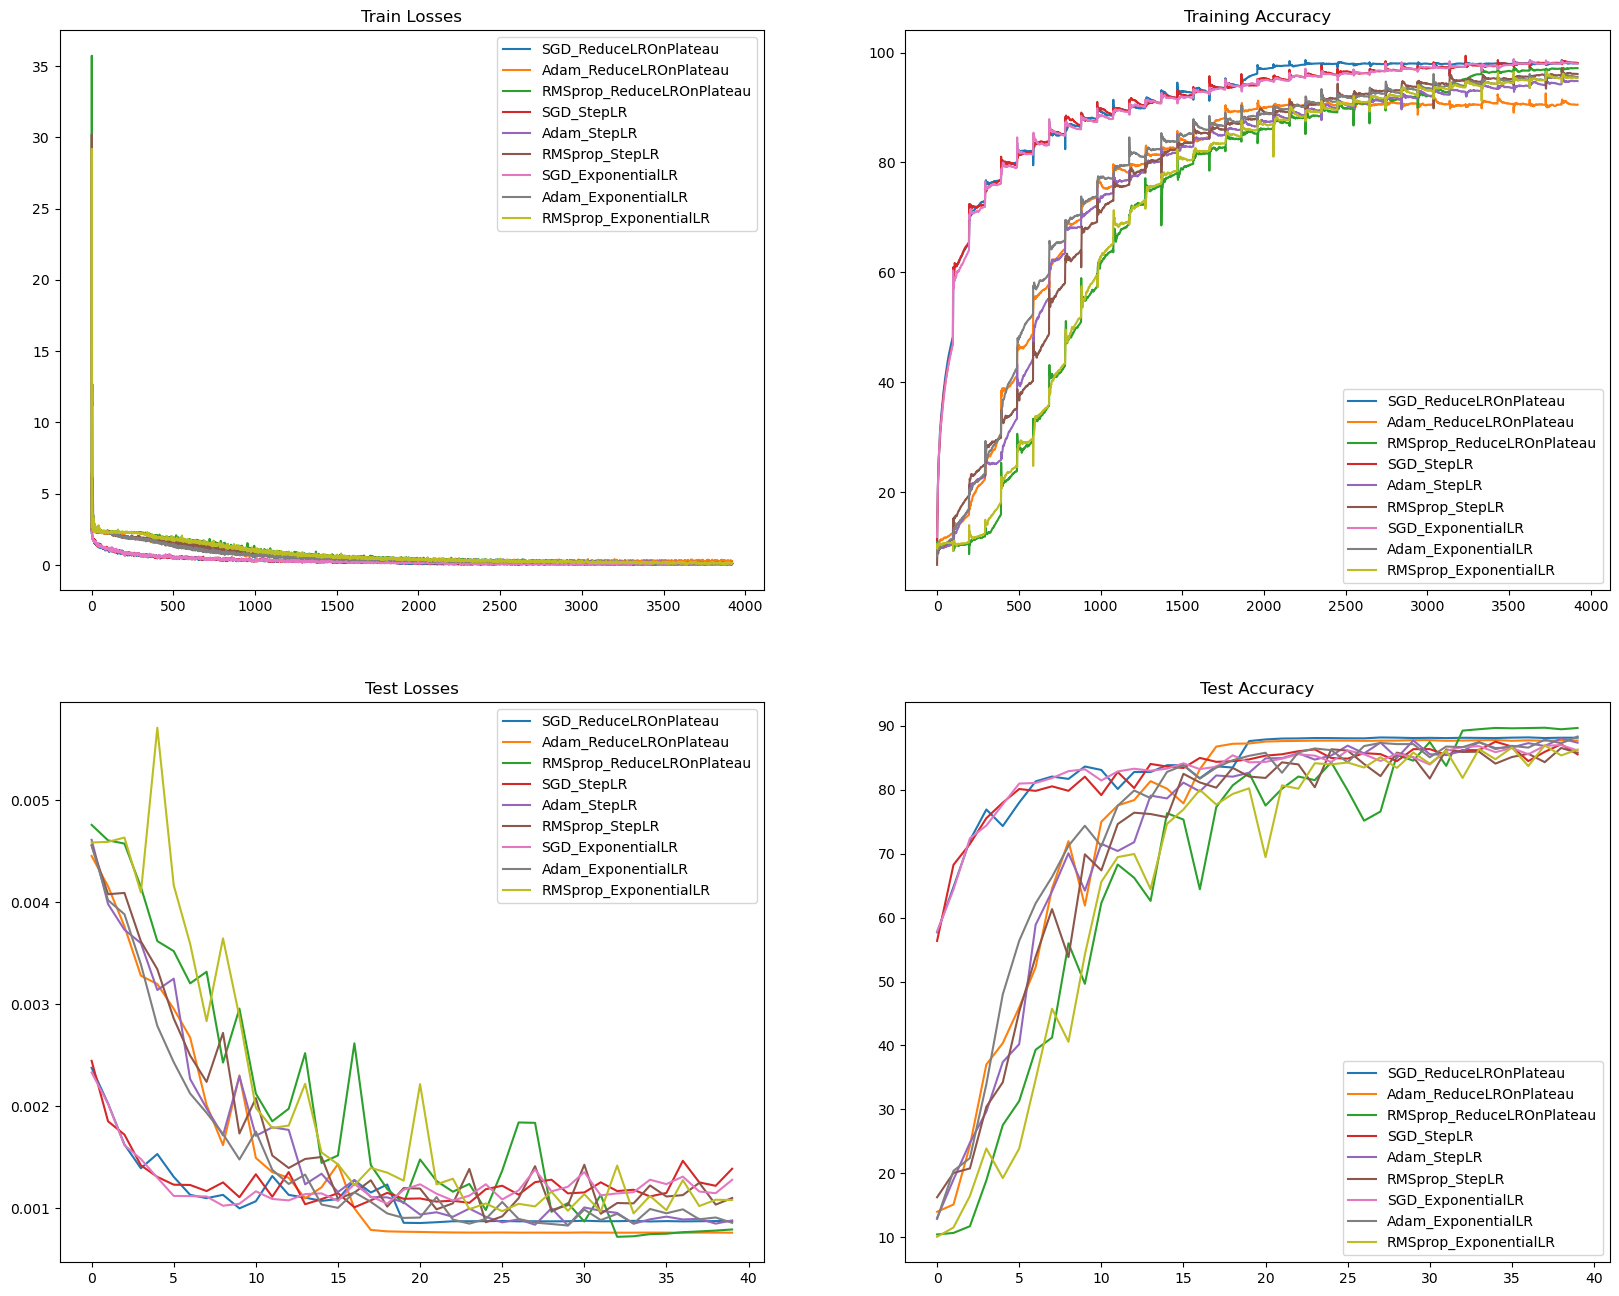

In [44]:
draw_cmp(common_model='vgg')

### 绘制排列组合

In [40]:
def all_draw_cmp():
    # for model in ['resnet', 'vgg']:
    for optimizer in ['SGD', 'Adam', 'RMSprop']:
        draw_cmp(common_optimizer=optimizer)
    for scheduler in ['ReduceLROnPlateau', 'StepLR', 'ExponentialLR']:
        draw_cmp(common_scheduler=scheduler)
    draw_cmp()

In [41]:
def free_draw(paths):
    results = []
    for path in paths:
        data = np.load(path)
        train_losses = data['train_losses']
        train_acc = data['train_acc']
        test_losses = data['test_losses']
        test_acc = data['test_acc']
        results.append({
            'config': path.split('/')[-1].split('.')[0].split('_', 1)[1],
            'train_acc': train_acc,
            'train_losses': train_losses,
            'test_acc': test_acc,
            'test_losses': test_losses
        })
    fig, axs = plt.subplots(2, 2, figsize=(20, 16))
    for result in results:
        axs[0, 0].plot(result['train_losses'], label=result['config'])
        axs[0, 1].plot(result['train_acc'], label=result['config'])
        axs[1, 0].plot(result['test_losses'], label=result['config'])
        axs[1, 1].plot(result['test_acc'], label=result['config'])
    axs[0, 0].set_title('Train Losses')
    axs[0, 1].set_title('Training Accuracy')
    axs[1, 0].set_title('Test Losses')
    axs[1, 1].set_title('Test Accuracy')
    for ax in axs.flat:
        ax.legend()
    os.makedirs('./fig/free', exist_ok=True)
    plt.savefig(f'./fig/free/free_{get_timestamp()}.png')
    plt.show()

In [ ]:
path1 = './metrics/metrics_resnet_SGD_ReduceLROnPlateau.npz'
path2 = './metrics/metrics_vgg_SGD_ReduceLROnPlateau.npz'
paths = [path1, path2]
free_draw(paths)

In [ ]:
all_draw_cmp()

## 继续训练

之前的vgg太短了没有收敛，这次长一点

In [ ]:
def continue_model(model_name='vgg', start_epoch=32, epoch=52):
    main(model_name=model_name, optimizer_name='SGD', scheduler_name='ReduceLROnPlateau', epoch=epoch, start_epoch=start_epoch)
    main(model_name=model_name, optimizer_name='SGD', scheduler_name='StepLR', epoch=epoch, start_epoch=start_epoch)
    main(model_name=model_name, optimizer_name='SGD', scheduler_name='ExponentialLR', epoch=epoch, start_epoch=start_epoch)
    main(model_name=model_name, optimizer_name='Adam', scheduler_name='Redu'
                                                                      'ceLROnPlateau', epoch=epoch, start_epoch=start_epoch)
    main(model_name=model_name, optimizer_name='Adam', scheduler_name='StepLR', epoch=epoch, start_epoch=start_epoch)
    main(model_name=model_name, optimizer_name='Adam', scheduler_name='ExponentialLR', epoch=epoch, start_epoch=start_epoch)
    main(model_name=model_name, optimizer_name='RMSprop', scheduler_name='ReduceLROnPlateau', epoch=epoch, start_epoch=start_epoch)
    main(model_name=model_name, optimizer_name='RMSprop', scheduler_name='StepLR', epoch=epoch, start_epoch=start_epoch)
    main(model_name=model_name, optimizer_name='RMSprop', scheduler_name='ExponentialLR', epoch=epoch, start_epoch=start_epoch)

In [ ]:
continue_model(model_name='vgg')

In [ ]:
main(model_name='vgg', optimizer_name='SGD', scheduler_name='ReduceLROnPlateau')
main(model_name='vgg', optimizer_name='SGD', scheduler_name='StepLR')
main(model_name='vgg', optimizer_name='SGD', scheduler_name='ExponentialLR')
main(model_name='vgg', optimizer_name='Adam', scheduler_name='ReduceLROnPlateau')

## 寻找最大值

In [79]:
import os
def max_test_acc(dir_path='./metrics'):
    # 遍历所有metrics，找到所有的测试准确率和相应的文件路径
    data_acc_paths = []
    datas = os.listdir(dir_path)
    for data_file in datas:
        if data_file.endswith('.npz'):
            data = np.load(f'{dir_path}/{data_file}')
            # 以最后三次的均值作为测试准确率
            test_acc = np.mean(data['test_acc'][-3:])
            data_acc_paths.append((test_acc, data_file))  # 将准确率和文件路径添加到列表中
    
    # 按照测试准确率降序排序
    data_acc_paths.sort(reverse=True)
    
    # 输出排序后的测试准确率和文件路径
    for test_acc, data_file in data_acc_paths:
        print(f"Test Accuracy: {test_acc:.2f}, File Path: {data_file}")

In [80]:
max_test_acc()

Test Accuracy: 89.58, File Path: metrics_vgg_RMSprop_ReduceLROnPlateau.npz
Test Accuracy: 89.02, File Path: metrics_resnet_SGD_ReduceLROnPlateau.npz
Test Accuracy: 88.09, File Path: metrics_vgg_SGD_ReduceLROnPlateau.npz
Test Accuracy: 87.78, File Path: metrics_vgg_Adam_ExponentialLR.npz
Test Accuracy: 87.67, File Path: metrics_vgg_Adam_ReduceLROnPlateau.npz
Test Accuracy: 87.55, File Path: metrics_resnet_SGD_StepLR.npz
Test Accuracy: 87.38, File Path: metrics_vgg_Adam_StepLR.npz
Test Accuracy: 87.14, File Path: metrics_resnet_Adam_ReduceLROnPlateau_1.npz
Test Accuracy: 87.14, File Path: metrics_resnet_Adam_ReduceLROnPlateau.npz
Test Accuracy: 87.13, File Path: metrics_resnet_RMSprop_ReduceLROnPlateau.npz
Test Accuracy: 86.77, File Path: metrics_resnet_SGD_ExponentialLR.npz
Test Accuracy: 86.64, File Path: metrics_vgg_SGD_ExponentialLR.npz
Test Accuracy: 86.17, File Path: metrics_vgg_RMSprop_ExponentialLR.npz
Test Accuracy: 86.16, File Path: metrics_vgg_SGD_StepLR.npz
Test Accuracy: 86.

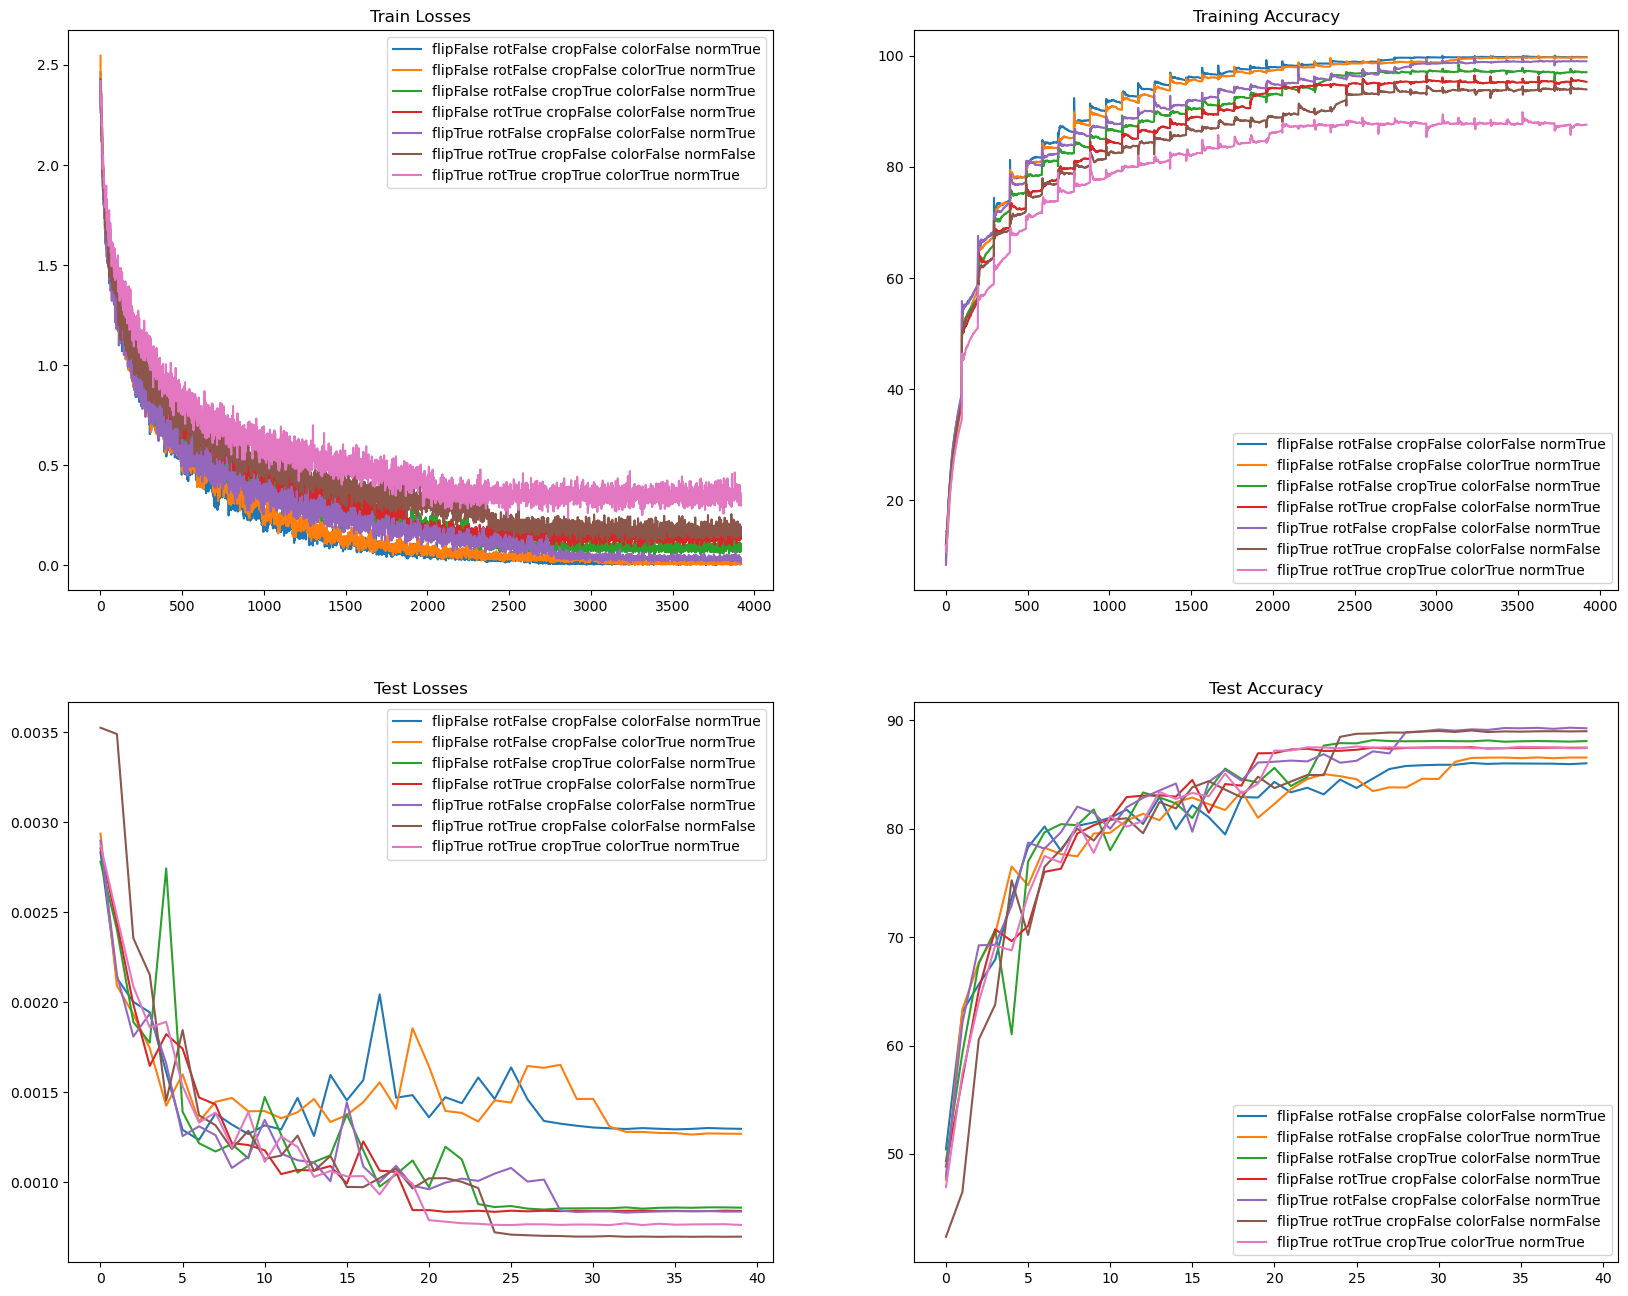

In [78]:
# 遍历 enf 下的所有 metrics, 绘制一个图
enf_datas = os.listdir('./metrics/enf')
enf_data_acc_paths = []
results = []
for data_file in enf_datas:
    if data_file.endswith('.npz'):
        data = np.load(f'./metrics/enf/{data_file}')
        exp = data_file.split('.')[0].split('_')[1:]
        # 去除后面的'_resnet_SGD_ReduceLROnPlateau'字符串
        exp = exp[:-3]
        exp = ' '.join(exp)
        test_acc = list(data['test_acc'])
        train_acc = list(data['train_acc'])
        train_losses = list(data['train_losses'])
        test_losses = list(data['test_losses'])
        results.append({
            'config': f"{exp}",
            'train_acc': train_acc,
            'train_losses': train_losses,
            'test_acc': test_acc,
            'test_losses': test_losses
        })


# 绘制结果
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
for result in results:
    axs[0, 0].plot(result['train_losses'], label=result['config'])
    axs[0, 1].plot(result['train_acc'], label=result['config'])
    axs[1, 0].plot(result['test_losses'], label=result['config'])
    axs[1, 1].plot(result['test_acc'], label=result['config'])

axs[0, 0].set_title('Train Losses')
axs[0, 1].set_title('Training Accuracy')
axs[1, 0].set_title('Test Losses')
axs[1, 1].set_title('Test Accuracy')

# 添加图例
for ax in axs.flat:
    ax.legend()

plt.savefig(f'./fig/cmp_enf.png')
plt.show()
        

In [83]:
max_test_acc('./metrics/enf')

Test Accuracy: 89.31, File Path: metrics_flipTrue_rotFalse_cropFalse_colorFalse_normTrue_vgg_RMSprop_ReduceLROnPlateau.npz
Test Accuracy: 89.28, File Path: metrics_flipTrue_rotFalse_cropFalse_colorFalse_normTrue_resnet_SGD_ReduceLROnPlateau.npz
Test Accuracy: 89.00, File Path: metrics_flipTrue_rotTrue_cropFalse_colorFalse_normFalse_resnet_SGD_ReduceLROnPlateau.npz
Test Accuracy: 88.40, File Path: metrics_flipFalse_rotFalse_cropTrue_colorFalse_normTrue_vgg_RMSprop_ReduceLROnPlateau.npz
Test Accuracy: 88.08, File Path: metrics_flipFalse_rotFalse_cropTrue_colorFalse_normTrue_resnet_SGD_ReduceLROnPlateau.npz
Test Accuracy: 87.49, File Path: metrics_flipFalse_rotTrue_cropFalse_colorFalse_normTrue_resnet_SGD_ReduceLROnPlateau.npz
Test Accuracy: 87.46, File Path: metrics_flipTrue_rotTrue_cropTrue_colorTrue_normTrue_resnet_SGD_ReduceLROnPlateau.npz
Test Accuracy: 86.56, File Path: metrics_flipFalse_rotFalse_cropFalse_colorTrue_normTrue_resnet_SGD_ReduceLROnPlateau.npz
Test Accuracy: 86.01, Fil

## 寻找最优解

激动了，我们来试试找到最好的结果！

In [ ]:
main(model_name='vgg', optimizer_name='RMSprop', scheduler_name='ReduceLROnPlateau', flip=True, rotate=False, random_crop=False, color_augment=False,normalize=True)
main(model_name='vgg', optimizer_name='RMSprop', scheduler_name='ReduceLROnPlateau', flip=True, rotate=True, random_crop=False, color_augment=False,normalize=False)
main(model_name='vgg', optimizer_name='RMSprop', scheduler_name='ReduceLROnPlateau', flip=False, rotate=False, random_crop=True, color_augment=False,normalize=True)